In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import duckdb
connection = duckdb.connect()
import os

# Collect

First step load all csv tables in one table and make a common format.

In [2]:
%%time
def get_csv(path):
    return list(map(lambda x: path+x.name,
                os.scandir(path)))



mexico =    pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_mex/meteorology/')])
altz =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_altzomoni/meteorology/')])
cham =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_chamela/meteorology/')])
herm =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_hermosillo/meteorology/')])
jur =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_juriquilla/meteorology/')])
agu =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_agsc/meteorology/')])
maz =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_maza/meteorology/')])
med =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_meda/meteorology/')])
mine =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_mine/meteorology/')])
ptom =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_ptom/meteorology/')])
sisal =     pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_sisal/meteorology/')])
sllo =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_sllo/meteorology/')])
texo =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_texo/meteorology/')])
tmix =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_tmix/meteorology/')])
tux =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_tux/meteorology/')])
morelia =   pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_morelia/meteorology/')])

Wall time: 1min 38s


Add a new column - region  
Set certain format for each column

In [3]:
%%time
morelia['region'] = 'Morelia'
altz['region'] = 'Altzomoni'
cham['region'] = 'Chamela'
herm['region'] = 'Hermosillo'
jur['region'] = 'Juriquilla'
agu['region'] = 'Aguascalientes'
maz['region'] = 'Mazatlan'
med['region'] = 'Merida'
mine['region'] = 'Mineria'
ptom['region'] = 'Puerto Morelos'
sisal['region'] = 'Sisal'
sllo['region'] = 'Saltillo'
texo['region'] = 'Texcoco'
tmix['region'] = 'Temixco'
tux['region'] = 'Los Tuxtlas'
mexico['region'] = 'Mexico'

df = pd.concat([morelia, altz, cham, herm, jur, agu, maz, med, mine, ptom, sisal, sllo, texo, tmix, tux, mexico])
df = df[df.TIMESTAMP != 'yyyy-mm-dd HH:MM:SS'].copy()
df = df.astype({'TIMESTAMP': 'datetime64[ns]',
	            'Temp_Avg': np.float32,
                'RH_Avg': np.float32,
                'WSpeed_Avg': np.float32,
                'WSpeed_Max': np.float32,
                'WDir_Avg': np.float32,
                'WDir_SD': np.float32,
                'Rain_Tot': np.float32,
                'Press_Avg': np.float32,
                'Rad_Avg': np.float32,
                'region': 'category',
                'Visibility': np.float32,
                'Visibility_Avg': np.float32,})

Wall time: 10min 7s


In [4]:
df = df.reset_index(drop=True)
df.head()

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,WDir_SD,Rain_Tot,Press_Avg,Rad_Avg,region,Visibility,Visibility_Avg
0,2015-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
1,2015-08-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
2,2015-08-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
3,2015-08-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
4,2015-08-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN


In [5]:
df.to_parquet('data/collected_data.parquet')

# Check data

Check do we have time holes in our data. 

In [12]:
df = pd.read_parquet('data/collected_data.parquet')
sql_command = '''
with t1 as (
    select 
        region, 
        min(TIMESTAMP),
        max(TIMESTAMP),
        from df
    group by region),

t2 as (
    select 
        region,
        date_trunc('month', TIMESTAMP) as month
        from df

    group by region, date_trunc('month', TIMESTAMP)
    order by region, date_trunc('month', TIMESTAMP)
) 
select * from t2
'''
dft = connection.execute(sql_command).df()
dft['lag'] = dft.month - dft.month.shift(1)
dft[dft.lag.between(pd.Timedelta(1, "d"), pd.Timedelta(3, "d"))].shape[0]

0

In [19]:
dft[dft.lag > pd.Timedelta(31, "d")]

,region,month,lag
92,Aguascalientes,2023-02-01,62 days
412,Hermosillo,2023-02-01,62 days
516,Juriquilla,2023-02-01,62 days
715,Mazatlan,2023-02-01,62 days
801,Merida,2023-02-01,92 days
907,Mexico,2023-02-01,62 days
968,Mineria,2023-02-01,62 days
1058,Morelia,2023-02-01,62 days
1183,Saltillo,2023-02-01,62 days
1252,Sisal,2023-02-01,62 days


In [21]:
%%time
df = connection.execute('''
with df as (
    select row_number() over(partition by region) as id, * from read_parquet(['data/collected_data.parquet'])
    where Temp_Avg is not NULL
)

select * from df
where id  < 250000
''').df().drop(columns=['id'])
df

Wall time: 37.4 s


,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,WDir_SD,Rain_Tot,Press_Avg,Rad_Avg,region,Visibility,Visibility_Avg
0,2018-04-05 19:09:00,27.260000,22.959999,3.878,4.68,10.110000,12.450000,0.0,871.914978,-1.127,Temixco,NaN,NaN
1,2018-04-05 19:10:00,27.200001,22.980000,4.498,5.55,23.600000,10.730000,0.0,871.841003,-1.230,Temixco,NaN,NaN
2,2018-04-05 19:11:00,27.209999,23.100000,3.890,4.46,23.030001,12.660000,0.0,871.747986,-1.196,Temixco,NaN,NaN
3,2018-04-05 19:12:00,27.250000,22.920000,4.713,7.21,9.050000,22.299999,0.0,871.898010,-1.196,Temixco,NaN,NaN
4,2018-04-05 19:13:00,27.299999,22.049999,6.595,7.67,334.299988,9.890000,0.0,871.877991,-1.845,Temixco,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999979,2020-02-12 12:59:00,27.110001,77.260002,7.630,8.43,152.699997,3.741000,0.0,1014.349976,883.000,Puerto Morelos,NaN,NaN
3999980,2020-02-12 13:00:00,27.139999,76.739998,8.750,8.91,150.600006,3.382000,0.0,1014.117981,884.000,Puerto Morelos,NaN,NaN
3999981,2020-02-12 13:01:00,27.090000,76.820000,7.997,8.25,148.100006,1.081000,0.0,1014.132019,898.000,Puerto Morelos,NaN,NaN
3999982,2020-02-12 13:02:00,27.080000,76.949997,8.330,9.18,147.300003,1.406000,0.0,1014.151978,891.000,Puerto Morelos,NaN,NaN


In [23]:
df = df.astype({'region': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999984 entries, 0 to 3999983
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   TIMESTAMP       datetime64[ns]
 1   Temp_Avg        float32       
 2   RH_Avg          float32       
 3   WSpeed_Avg      float32       
 4   WSpeed_Max      float32       
 5   WDir_Avg        float32       
 6   WDir_SD         float32       
 7   Rain_Tot        float32       
 8   Press_Avg       float32       
 9   Rad_Avg         float32       
 10  region          category      
 11  Visibility      float32       
 12  Visibility_Avg  float32       
dtypes: category(1), datetime64[ns](1), float32(11)
memory usage: 202.2 MB


## Region distribution

In [24]:
df.region.astype(str).unique()

array(['Temixco', 'Juriquilla', 'Mineria', 'Morelia', 'Texcoco',
       'Chamela', 'Aguascalientes', 'Hermosillo', 'Mazatlan', 'Saltillo',
       'Merida', 'Sisal', 'Los Tuxtlas', 'Altzomoni', 'Mexico',
       'Puerto Morelos'], dtype=object)

In [35]:
def plot_distribution(dft):
    a = sns.color_palette('magma', 9)
    dft = dft.astype({'region' : str})
    _, axs = plt.subplots(3, 3, figsize=(10, 6), dpi=150)
    cols = dft.columns[1:]
    n = 0
    for i in range(3):
        for j in range(3):
            sns.histplot(data=dft, 
                        x=cols[n], bins=100, ax=axs[i, j], color=a[n], stat='density', hue='region', kde=True)
            if i + j != 4:
                axs[i, j].legend(frameon=False)
            box = axs[i, j].get_position()
            axs[i, j].set_position([box.x0 + j * 0.05, box.y0 - i * 0.05, box.width, box.height])
            n+=1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

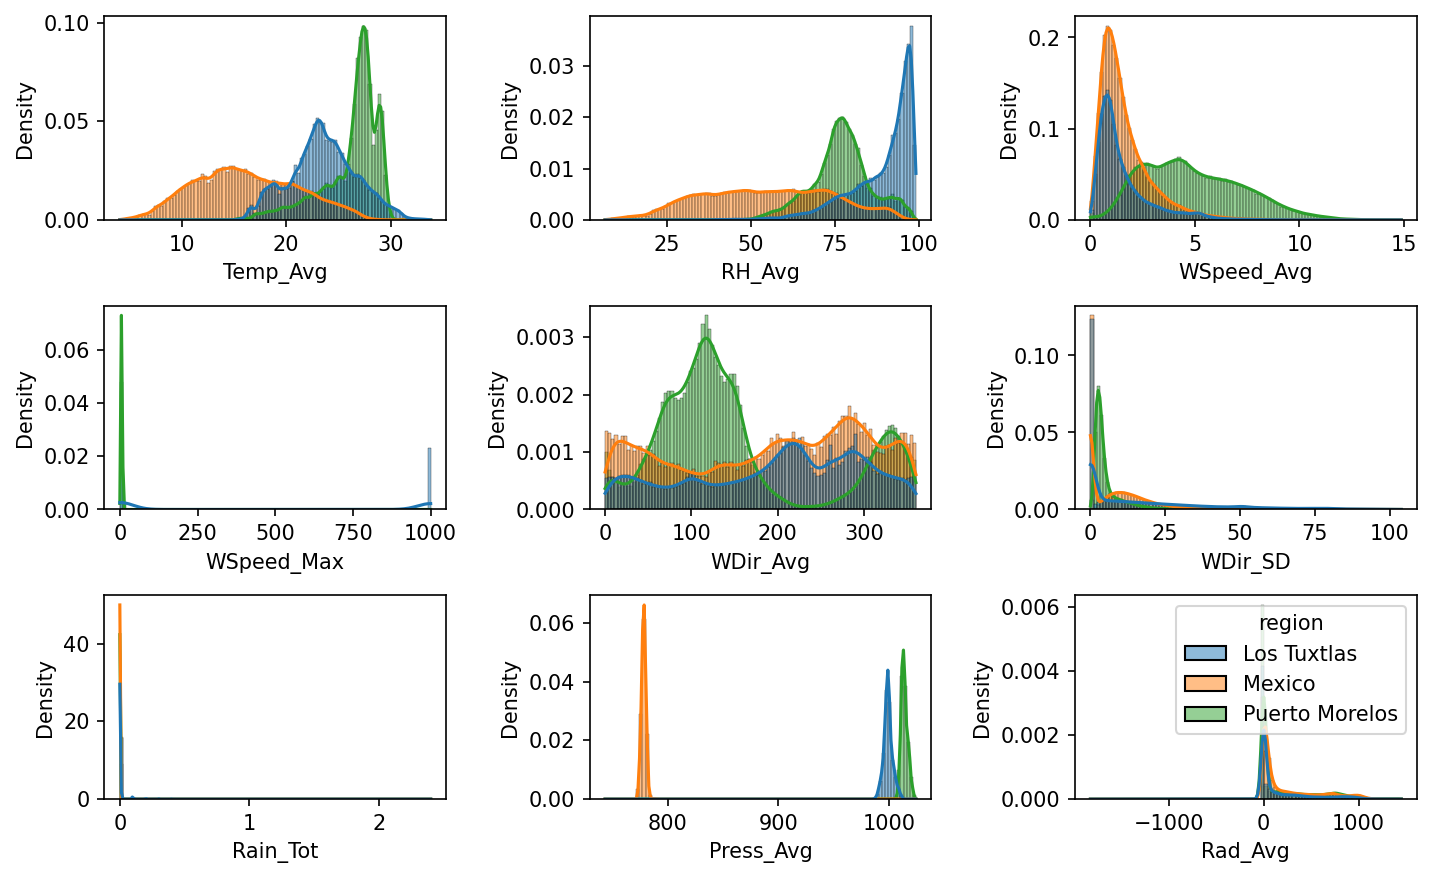

In [36]:
plot_distribution(df[df.region.isin({'Los Tuxtlas', 'Mexico', 'Puerto Morelos'})].copy())

# Clean data

Temp_Avg Z_value   
RH_avg 1-99  
WSpeed_AVG 0 - 0.995  
WSpeed_Max 0 - 0.995  
WDir_AVG 0.001 - 359.999  
**WDir_SD 0.001 - 359.999**  
Rain_Tot 0 - inf  
Press_Avg Z_value  
Rad_Avg > 0.001  (replace to NULL)

In [39]:
%%time
from scipy import stats

def q005(arr):
    return arr.quantile(0.005)

def q01(arr):
    return arr.quantile(0.01)

def q995(arr):
    return arr.quantile(0.995)

def q995(arr):
    return arr.quantile(0.995)

def q98(arr):
    return arr.quantile(0.98)

def q99(arr):
    return arr.quantile(0.99)

df = pd.read_parquet('data/collected_data.parquet')
dft = df.groupby('region').agg(WSpeed_AVG_qh=('WSpeed_Avg', q99),
                            WSpeed_Max_qh=('WSpeed_Max', q98),
                            press_avg=('Press_Avg', 'mean'),
                            press_std=('Press_Avg', 'std'),
                            temp_avg=('Temp_Avg', 'mean'),
                            temp_std=('Temp_Avg', 'std'),
                            ).reset_index()

Wall time: 10.6 s


In [40]:
dft

,region,WSpeed_AVG_qh,WSpeed_Max_qh,press_avg,press_std,temp_avg,temp_std
0,Aguascalientes,6.935,7.820,816.817688,2.364958,18.908230,5.651476
1,Altzomoni,12.050,13.130,634.137939,4.606856,5.125785,2.894821
2,Chamela,7.860,8.660,990.198730,65.683496,25.099041,6.207235
3,Hermosillo,6.590,7.560,988.529053,3.288344,24.809774,9.381442
4,Juriquilla,7.698,9.060,809.061462,2.401796,18.676325,5.315475
5,Los Tuxtlas,5.085,1000.000,998.861877,4.417763,23.791061,3.535697
6,Mazatlan,11.200,7.503,1010.089722,2.392358,24.519390,11.006781
7,Merida,7.710,9.040,1012.964783,3.585219,27.104521,4.022672
8,Mexico,5.542,6.710,778.043762,7.780187,16.877085,4.601780
9,Mineria,4.862,5.675,781.097351,2.042366,18.036591,4.157032


In [41]:
%%time
df = connection.execute('''
with qz as (select *, 
    (df.Press_Avg - dft.press_avg)/dft.press_std as press_zvalue, 
    (df.Temp_Avg - dft.temp_avg)/dft.temp_std as temp_zvalue, 
    
    from df

    left join dft on dft.region = df.region)

select 
    TIMESTAMP,
    region,
    CASE when 
        ( 
            (temp_zvalue between -2 and 2) or (Temp_Avg is NULL)
        )
        then Temp_Avg else NULL
    END as Temp_Avg,

    CASE when
        (
            (WSpeed_AVG between 0 and WSpeed_AVG_qh) or (WSpeed_AVG is NULL)
        )
        then WSpeed_AVG else NULL
    END as WSpeed_AVG,

    CASE when
        (
            (WSpeed_Max between 0 and WSpeed_Max_qh) or (WSpeed_Max is NULL)
        )
        then WSpeed_Max else NULL
    END as WSPeed_Max,

    CASE when
        (
            (WDir_SD between 0.001 and 359.999) or (WDir_SD is NULL)
        )
        then WDir_SD else NULL
    END as WDir_SD,

    CASE when
        (
            (Rain_Tot >= 0) or (Rain_Tot is NULL)
        )
        then Rain_Tot else NULL
    END as Rain_Tot,

    CASE when
        (
            (press_zvalue between -3 and 3) or (Press_Avg is NULL)
        )
        then Press_Avg else NULL
    END as Press_Avg,

    CASE when
        (
            (Rad_Avg > 0.001) or (Rad_Avg is NULL)
        )
        then Rad_Avg else NULL
    END as Rad_Avg,

    CASE when
        (
            (Visibility_Avg between 500 and 19000) or (Visibility_Avg is NULL)
        )
        then Visibility_Avg else NULL
    END as Visibility_Avg,

    CASE when
        (
            (Visibility between 500 and 19000) or (Visibility is NULL)
        )
        then Visibility else NULL
    END as Visibility,

    CASE when
        (
            (RH_Avg between 1 and 99) or (RH_Avg is NULL)
        ) 
        then RH_Avg else NULL
    END as RH_Avg,

    CASE when 
        (
            (WDir_AVG between 0.001 and 359.999) or (WDir_AVG is NULL)
        )
        then WDir_AVG else NULL
    END as WDir_AVG
    

from qz
''').df()

Wall time: 17 s


In [42]:
df.describe()

,Temp_Avg,WSpeed_AVG,WSPeed_Max,WDir_SD,Rain_Tot,Press_Avg,Rad_Avg,Visibility_Avg,Visibility,RH_Avg,WDir_AVG
count,4.933124e+07,4.950593e+07,3.488840e+07,5.051151e+07,5.167146e+07,4.974071e+07,2.859819e+07,230778.000000,7965.000000,4.935768e+07,5.065202e+07
mean,2.038953e+01,2.735670e+00,1.164451e+01,1.273363e+01,1.663918e-03,8.788923e+02,4.206224e+02,11742.183594,5606.524414,6.158133e+01,1.698720e+02
std,1.044499e+01,1.893666e+00,9.034465e+01,1.133861e+01,1.112994e+00,4.205222e+02,3.449702e+02,4861.594238,2082.726318,2.839321e+01,9.999560e+01
min,-6.630000e-01,0.000000e+00,0.000000e+00,2.000000e-03,0.000000e+00,6.204000e+02,2.000000e-03,500.100006,510.600006,1.000000e+00,1.000000e-03
25%,1.582000e+01,1.290000e+00,1.690000e+00,5.436000e+00,0.000000e+00,8.045090e+02,8.270000e+01,8184.750000,3987.000000,4.309000e+01,8.030000e+01
50%,2.149000e+01,2.255000e+00,2.900000e+00,9.610000e+00,0.000000e+00,8.265330e+02,3.552000e+02,12259.950195,4544.000000,6.598000e+01,1.558000e+02
75%,2.579000e+01,3.700000e+00,4.720000e+00,1.569000e+01,0.000000e+00,1.000816e+03,7.255000e+02,15914.574219,7999.000000,8.160000e+01,2.633000e+02
max,4.653000e+01,1.360000e+01,1.000000e+03,1.039000e+02,7.999000e+03,1.025207e+03,1.650000e+03,19000.000000,7999.000000,9.900000e+01,3.599000e+02


In [43]:
df.to_parquet('data/cleaned.parquet')

In [45]:
connection.execute('''
select count(*) from read_parquet(['data/cleaned.parquet'])
''').df()

,count_star()
0,59694708


# Data analyse 

## Time series

In [46]:
sql_command = '''
with df as (
    select 
        date_trunc('hour', TIMESTAMP) as time,
        Temp_Avg,
        region,
        RH_Avg,
        WSpeed_Avg,
        WDir_Avg,
        WDir_SD,
        Rain_Tot,
        Press_Avg,
        Rad_Avg,
        Visibility_Avg
    
    from read_parquet(['data/cleaned.parquet'])
    ),

hour as (
        select 
        time,
        region, 
        avg(Temp_Avg) as temp,
        avg(RH_Avg) as rh,
        avg(WSpeed_Avg) as wspeed_avg,
        avg(WDir_Avg) as wdir_avg,	
        avg(WDir_SD) as wdir_sd,
        avg(Rain_Tot) as rain_tot,
        avg(Press_Avg) as press,
        avg(Rad_Avg) as rad,
        avg(Visibility_Avg) as visibility_avg

    from df
        group by time, region
    )

select *, date_part('week', time) as week, date_part('hour', time) as hour, date_part('month', time) as month, 
    date_trunc('day', time) as time_day, date_trunc('week', time) as time_week, date_trunc('month', time) as time_month
from hour
'''

df = connection.execute(sql_command).df()
df = df[df.isna().sum(axis=1) < 4].copy()
df = df.reset_index(drop=True)

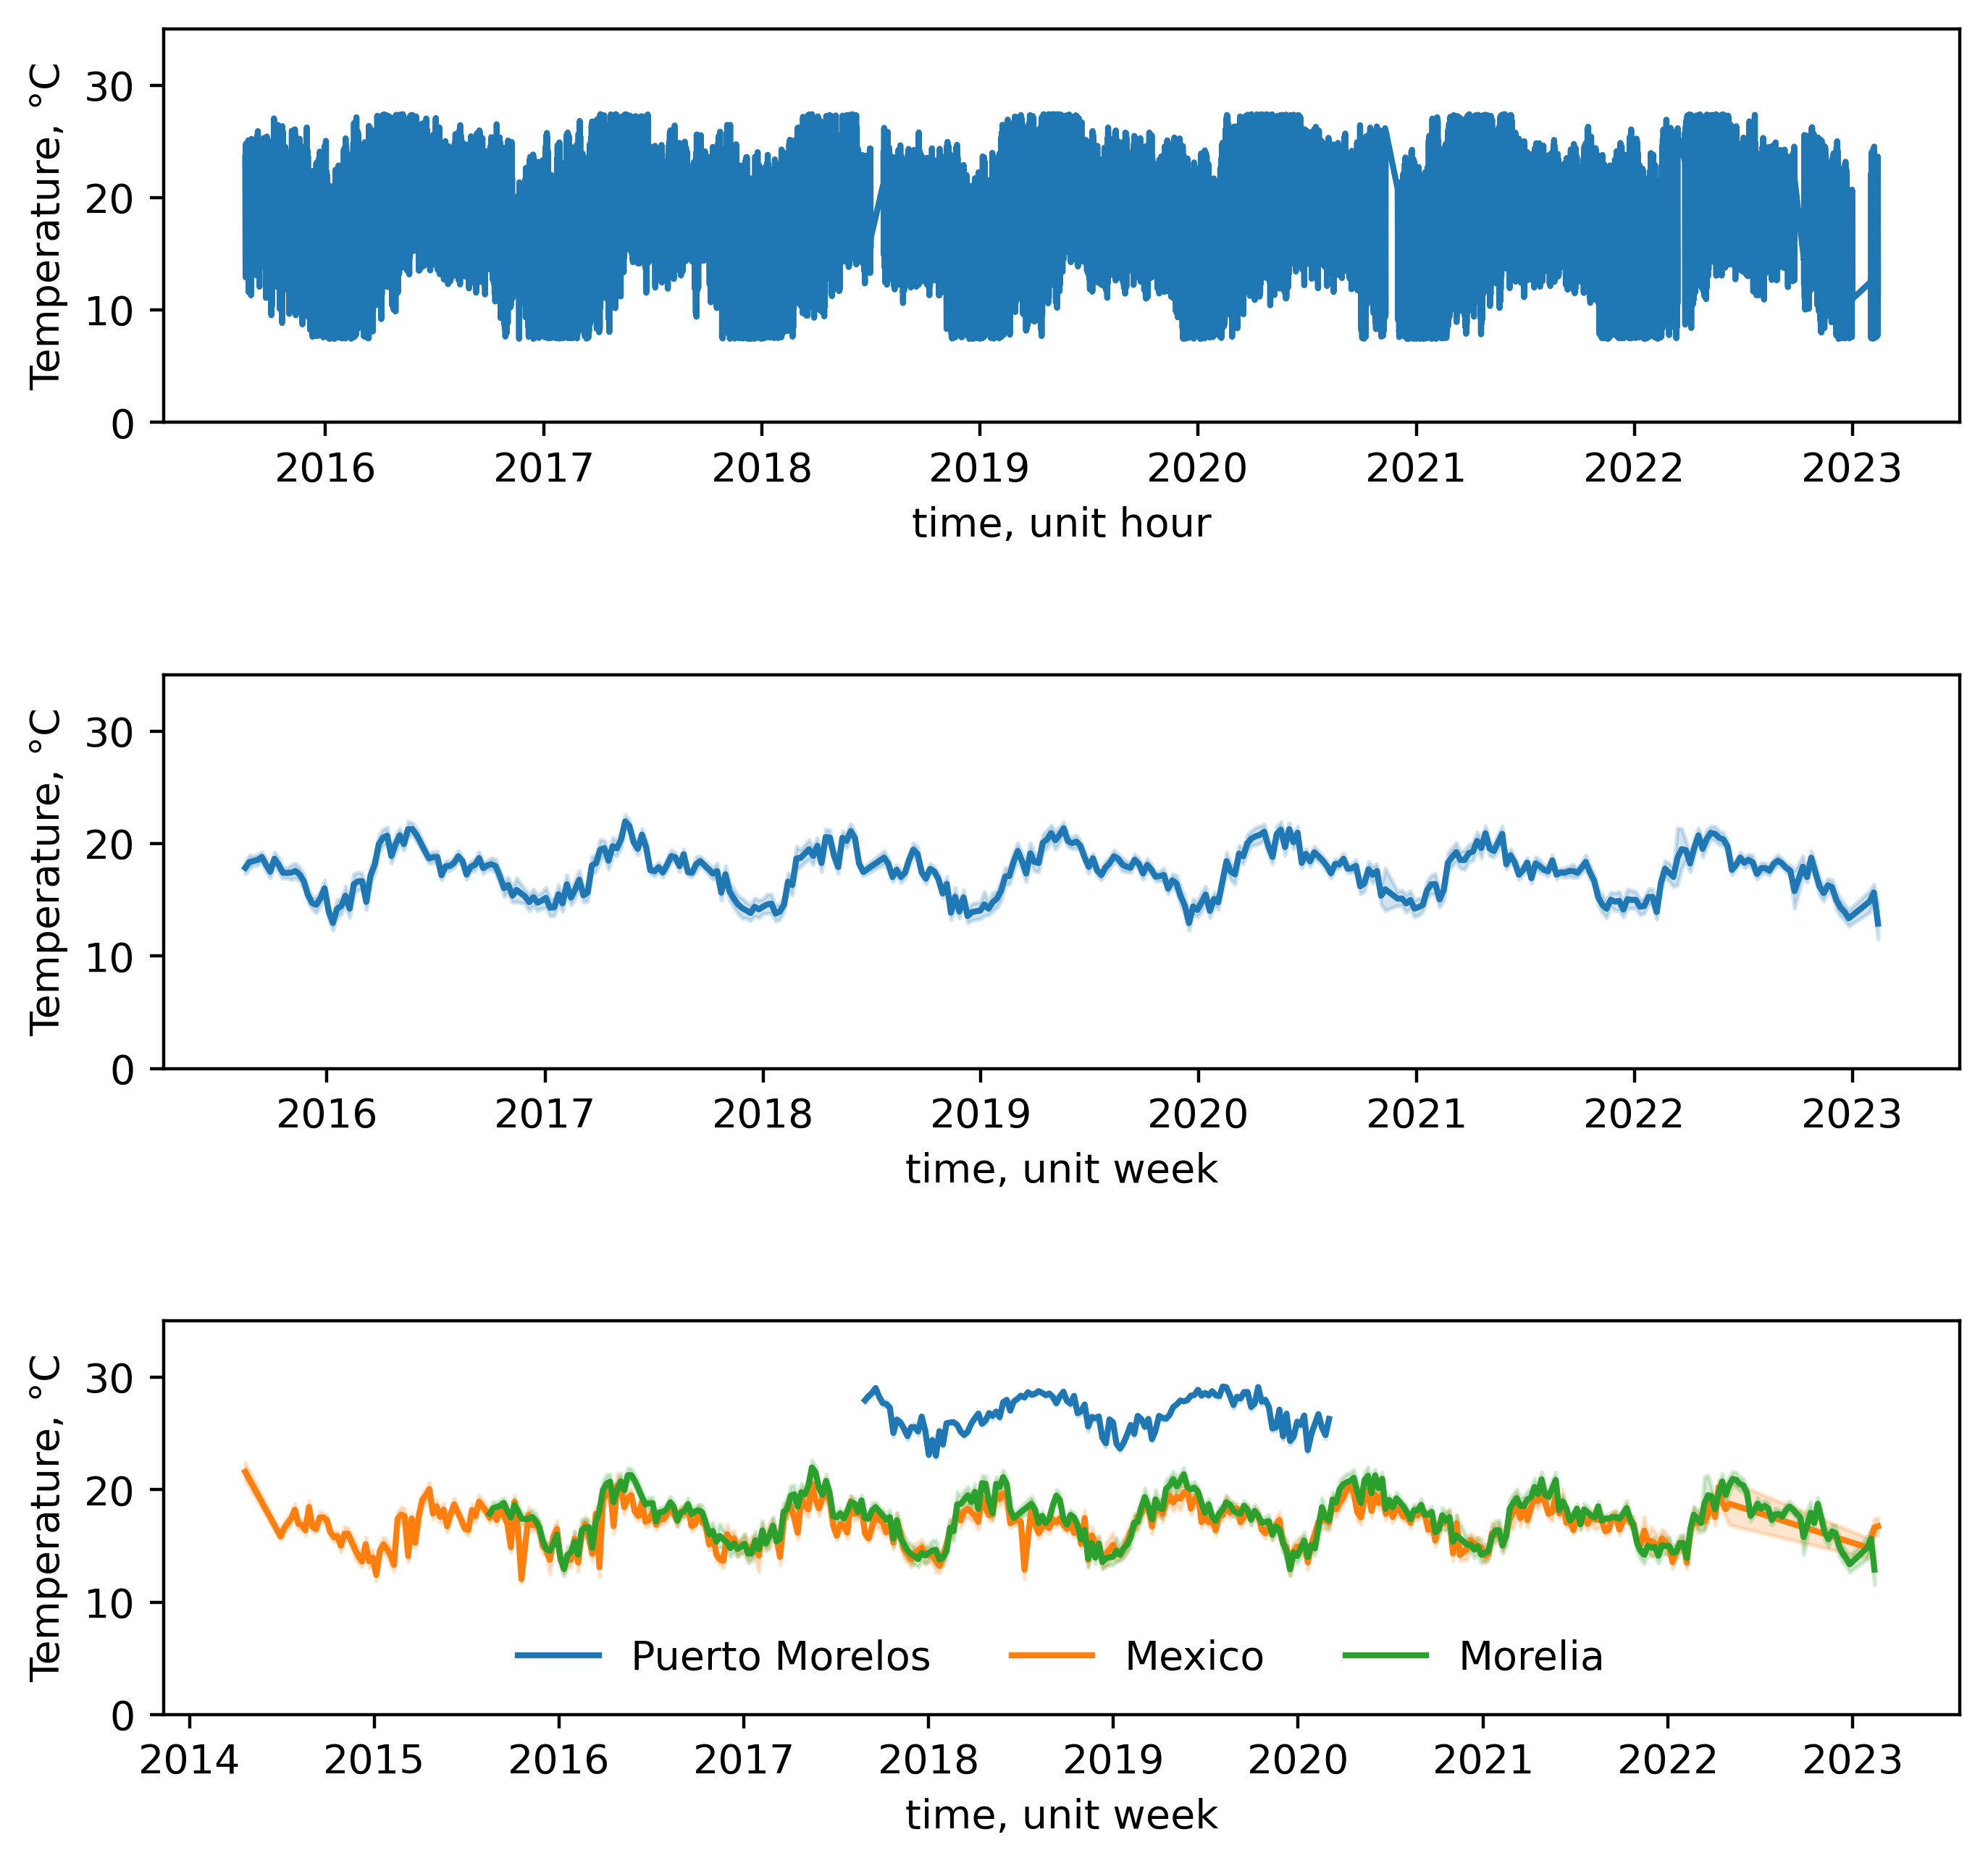

In [47]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), dpi=400)
sns.lineplot(data=df[df.region=='Morelia'], x='time', y='temp', ax=ax[0])
sns.lineplot(data=df[df.region=='Morelia'], x='time_week', y='temp', ax=ax[1])
sns.lineplot(data=df[df.region.isin({'Morelia', 'Mexico', 'Puerto Morelos'})], x='time_week', y='temp', hue='region', ax=ax[2])


for i in range(3):
    ax[i].set_ylabel('Temperature, °C')
    ax[i].set_ylim([0, 35])
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0 - i * 0.1, box.width, box.height])

ax[0].set_xlabel('time, unit hour')
ax[1].set_xlabel('time, unit week')
ax[2].set_xlabel('time, unit week')
ax[2].legend(loc='lower center', frameon=False, ncol=3)

## Distribution of different variables

Text(0, 0.5, '')

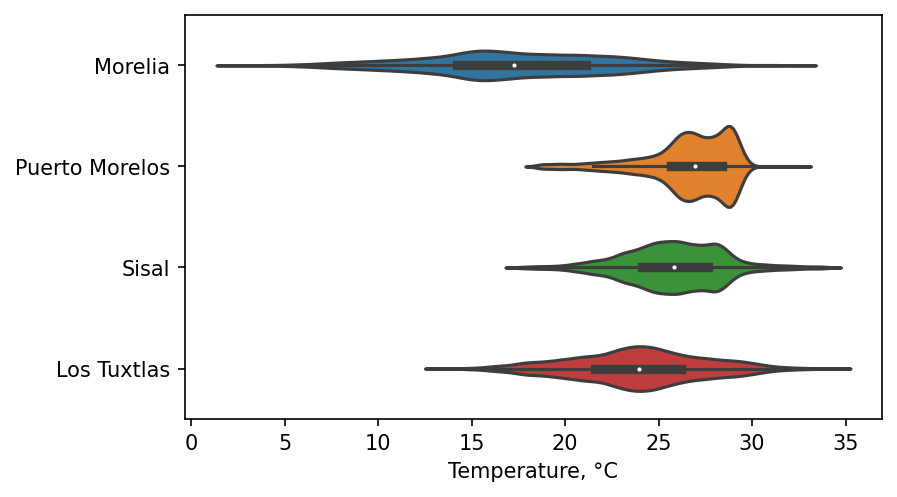

In [21]:
fig, ax = plt.subplots(figsize=(6, 3.5), dpi=150)
sns.violinplot(data=df[df.region.isin({'Morelia', 'Puerto Morelos', 'Sisal', 'Mesico', 'Los Tuxtlas'})], x='temp', y='region', ax=ax)
ax.set_xlabel('Temperature, °C')
ax.set_ylabel('')

## Wind Rose

In [6]:
from windrose import WindroseAxes
import matplotlib.cm as cm
from math import pi

In [7]:
df.region.unique()

array(['Mazatlan', 'Merida', 'Mineria', 'Puerto Morelos', 'Sisal',
       'Saltillo', 'Texcoco', 'Temixco', 'Los Tuxtlas', 'Mexico',
       'Morelia', 'Altzomoni', 'Chamela', 'Hermosillo', 'Juriquilla',
       'Aguascalientes'], dtype=object)

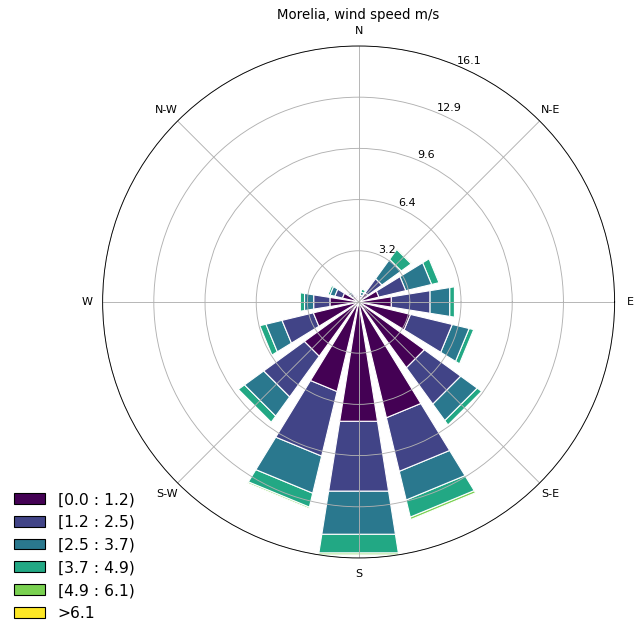

In [14]:
def get_wr(region='Morelia'):
    ax = WindroseAxes.from_ax()
    dft = df.loc[df.region==region, ['wdir_avg', 'wspeed_avg']]
    dft = dft.dropna()
    ax.bar(dft.wdir_avg, dft.wspeed_avg, normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    ax.set_title(f'{region}, wind speed m/s');
    

get_wr('Morelia')
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)


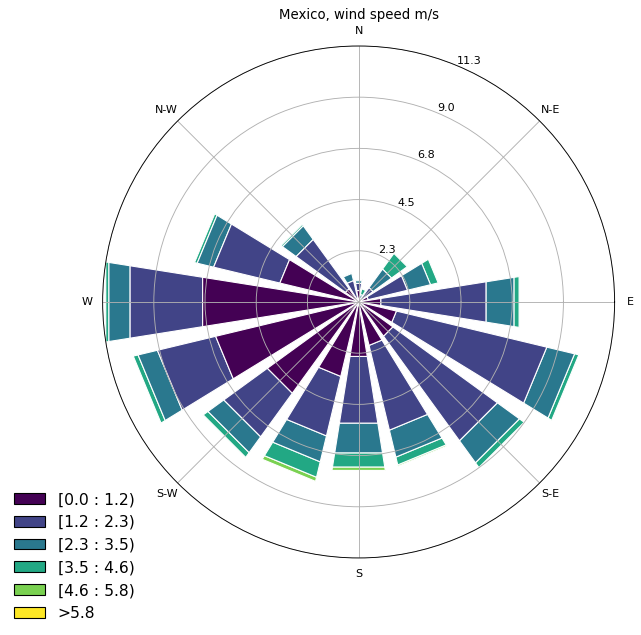

In [15]:
get_wr('Mexico')
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

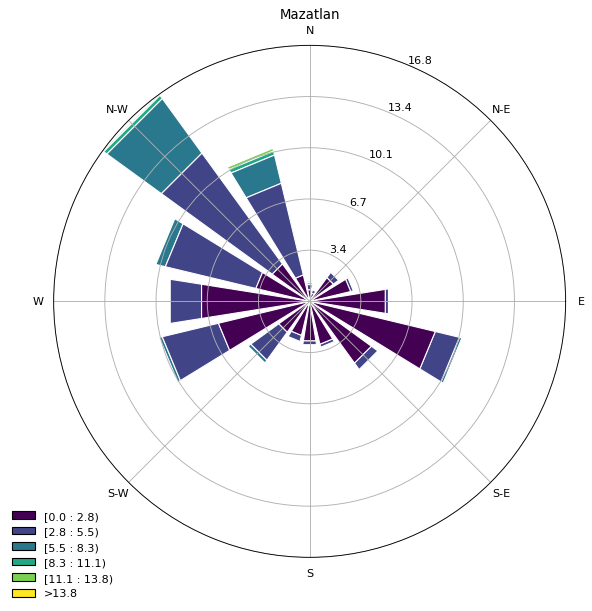

In [19]:
get_wr('Mazatlan')
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.1, -0.1])

## Seasonality 

In [48]:
sql_command = '''

with df as (
    select 
    date_part('hour', TIMESTAMP) as hour, 
    date_part('month', TIMESTAMP::date) as month, 
    * from read_parquet(['data/cleaned.parquet'])
    ),


    
t1 as (
    select 
        hour,
        month, 
        region, 
        avg(Temp_Avg) as temp,
        avg(RH_Avg) as rh,
        avg(WSpeed_Avg) as wspeed_avg,
        avg(WDir_Avg) as wdir_avg,	
        avg(WDir_SD) as wdir_sd,
        avg(Rain_Tot) as rain_tot,
        avg(Press_Avg) as press,
        avg(Rad_Avg) as rad,
        avg(Visibility_Avg) as visibility_avg
        from df group by region, month, hour
        )

select 
    month * 24 + hour - 24 as x_axis, 
    * 
    from t1 order by month, hour
'''
df = connection.execute(sql_command).df()

Seasonalyty of temperature during a day in different months.

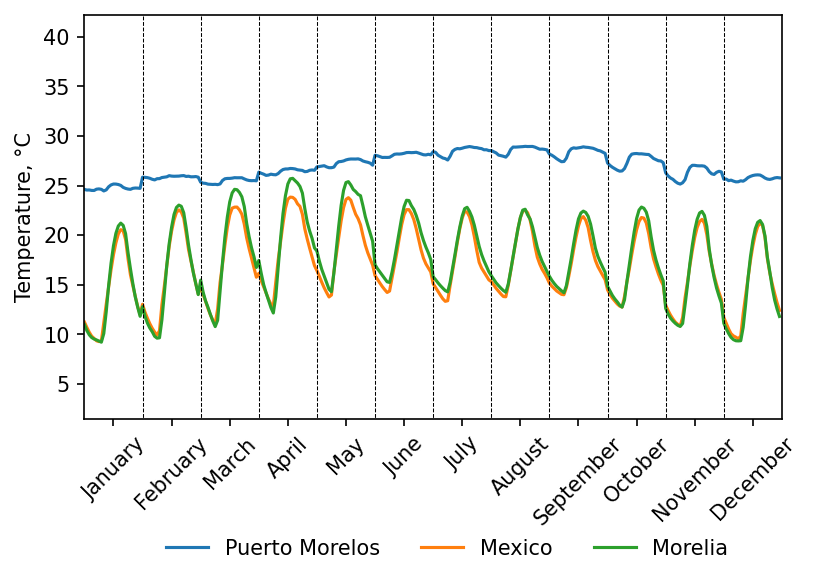

In [49]:
def show_day_month_seasonality(y_axis='temp'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), dpi=150)
    sns.lineplot(data = df[df.region.isin({'Morelia', 'Mexico', 'Puerto Morelos'})], x='x_axis', y=y_axis, hue='region', ax=ax)
    ax.set_xticks([24*i - 12 for i in range(1, 13)])
    ax.set_xticklabels(['January', 'February', 
                        'March', 'April', 'May', 
                        'June', 'July', 'August', 
                        'September', 'October', 
                        'November', 'December'], rotation=45);

    ax.vlines([i*24 for i in range(1, 13)], [-1e6]*12, [1e6]*12, linestyles='--', color='black', linewidth=0.5)
    ax.set_xlim([0, 24*12])
    ax.set_ylim([min(df[y_axis].min()*0.9, df[y_axis].min()*1.1), 
                max(df[y_axis].max()*0.9, df[y_axis].max()*1.1),])
    
    ax.legend(ncol=6, bbox_to_anchor = [0.95, -0.25], frameon=False,)
    ax.set_ylabel('Temperature, °C')
    ax.set_xlabel('')

show_day_month_seasonality('temp')